In [48]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import os

import cv2
import tensorflow

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy


# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [49]:
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

NUM_HOLDOUT_IMAGES = 200

NUM_EPOCHS = 10
NUM_FOLDS = 5

PADDING = 10
BATCH_SIZE = 10


NUM_FINAL_MODEL_EPOCHS = 10

In [50]:
pwd

'/home/kapil/Downloads/project/malaria_detection'

In [51]:
path_uninfected = './cell_images/Uninfected'
path_parasitized = './cell_images/Parasitized'

uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


In [52]:
for item in uninfected_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Uninfected folder: ', item)

Uninfected folder:  Thumbs.db


In [53]:
for item in parasitized_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Parasitized folder: ',item)

Parasitized folder:  Thumbs.db


In [54]:
# create the dataframe
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])

# remove the non image file
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']

# add a target column
df_uninfected['target'] = 0


# create the dataframe
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])

# remove the non image file
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']

# add a target column
df_parasitized['target'] = 1

#print(df_uninfected.shape)
#print(df_parasitized.shape)

# Combine the two dataframes

df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)

#df_combined.shape

In [55]:
df_combined.head()

,image_id,target
0,C202ThinF_IMG_20151015_152200_cell_226.png,0
1,C207ThinF_IMG_20151029_143952_cell_23.png,0
2,C78P39ThinF_IMG_20150606_104426_cell_24.png,0
3,C50P11thinF_IMG_20150724_115603_cell_72.png,0
4,C220ThinF_IMG_20151106_154339_cell_170.png,0


In [56]:
df_combined.shape

(27558, 2)

In [57]:
df_combined['image_id'].nunique()

27558

In [58]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    
    path_uninfected = './cell_images/Uninfected/'
    path_parasitized = './cell_images/Parasitized/'
     
    if file_name in uninfected_list:
        
        path = path_uninfected
        
    else:
        path = path_parasitized
    
    
    image = cv2.imread(path + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    img_format = file_name.split('.')[1]
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

m = np.stack(df_combined['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

df_combined = pd.concat([df_combined,df],axis=1, sort=False)

df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C202ThinF_IMG_20151015_152200_cell_226.png,0,151,127,3,205,0,png
1,C207ThinF_IMG_20151029_143952_cell_23.png,0,154,124,3,209,0,png
2,C78P39ThinF_IMG_20150606_104426_cell_24.png,0,118,121,3,209,0,png
3,C50P11thinF_IMG_20150724_115603_cell_72.png,0,136,118,3,216,0,png
4,C220ThinF_IMG_20151106_154339_cell_170.png,0,148,172,3,204,0,png
5,C221ThinF_IMG_20151106_155857_cell_82.png,0,133,136,3,205,0,png
6,C57P18thinF_IMG_20150729_110134_cell_89.png,0,142,124,3,223,0,png
7,C62P23N_ThinF_IMG_20150818_132918_cell_146.png,0,127,121,3,225,0,png
8,C140P101ThinF_IMG_20151005_210207_cell_73.png,0,166,127,3,227,0,png
9,C240ThinF_IMG_20151127_115545_cell_63.png,0,124,115,3,204,0,png


In [59]:
df_combined['c'].value_counts()

3    27558
Name: c, dtype: int64

In [60]:
df_combined['image_format'].value_counts()

png    27558
Name: image_format, dtype: int64

In [61]:
len(df_combined[(df_combined['max_pixel_val'] == 0) & (df_combined['max_pixel_val'] == 0)])

0

In [62]:
len(df_combined[(df_combined['max_pixel_val'] == 255) & (df_combined['max_pixel_val'] == 255)])

0

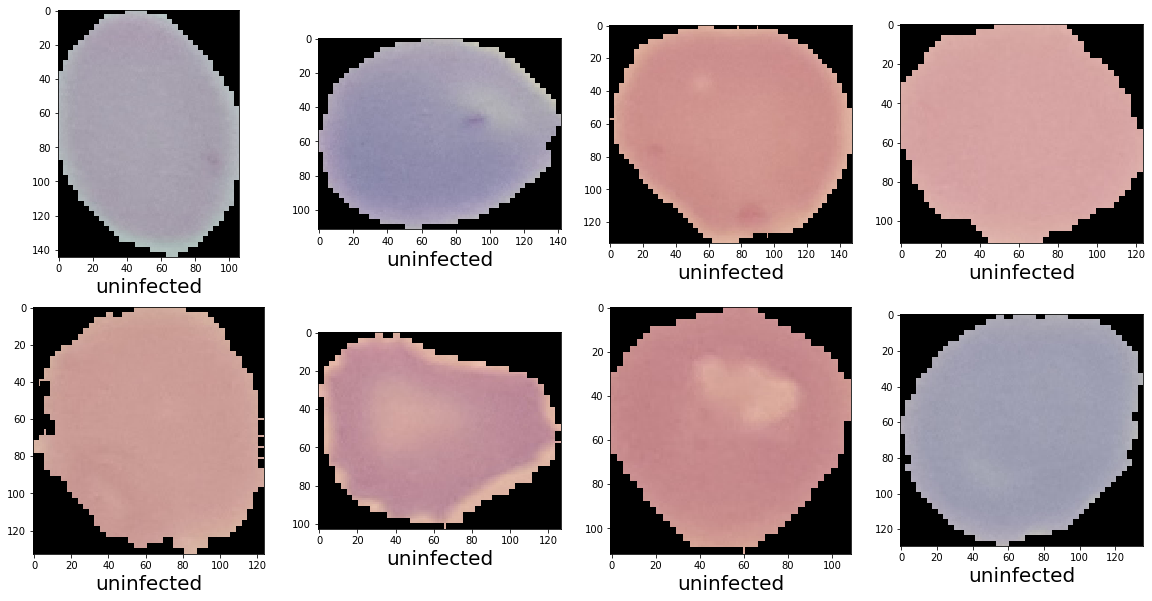

In [63]:
path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_uninfected['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('uninfected', fontsize=20)

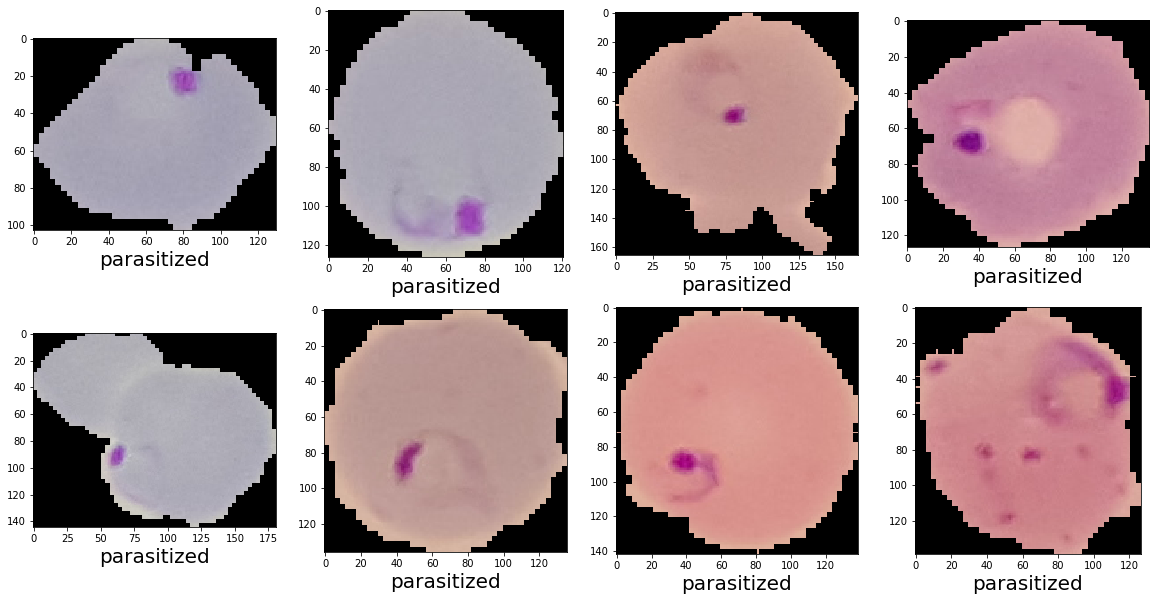

In [64]:
path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_parasitized['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.xlabel('parasitized', fontsize=20)

In [65]:
# shuffle
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

In [66]:
df_holdout.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
12152,C107P68ThinF_IMG_20150924_222233_cell_77.png,0,136,148,3,228,0,png
24272,C39P4thinF_original_IMG_20150622_111326_cell_2...,1,103,124,3,223,0,png
16731,C70P31_ThinF_IMG_20150813_131708_cell_7.png,1,151,121,3,217,0,png
22176,C39P4thinF_original_IMG_20150622_105554_cell_1...,1,160,124,3,219,0,png
25394,C60P21thinF_IMG_20150804_113602_cell_122.png,1,151,214,3,220,0,png


In [67]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [68]:
# Check the target distribution in the holdout set.
# 0 = uninfected
# 1 = parasitized

df_holdout['target'].value_counts()

1    104
0     96
Name: target, dtype: int64

In [69]:
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [70]:
!ls

base_dir  cell_images  Untitled.ipynb


In [71]:
os.listdir('base_dir')

['val_dir', 'train_dir']

In [72]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [73]:
# Check the target distribution of the val set.
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

In [74]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [75]:
df_data.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C145P106ThinF_IMG_20151016_154719_cell_124.png,0,127,115,3,194,0,png
C45P6ThinF_IMG_20151130_155110_cell_201.png,1,100,133,3,218,0,png
C175P136NThinF_IMG_20151127_142009_cell_241.png,1,154,139,3,210,0,png
C99P60ThinF_IMG_20150918_141351_cell_121.png,1,169,148,3,230,0,png
C113P74ThinF_IMG_20150930_134751_cell_174.png,1,130,151,3,230,0,png


In [76]:
path_uninfected = './cell_images/Uninfected'
path_parasitized = './cell_images/Parasitized'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)
        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)
        


# Transfer the val images

for image in val_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
        
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


In [77]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11630
11624
2053
2051


In [78]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [79]:
# Note that here we are normalizing the images inside the generator.
# If you wanted to add some data augmentation you could do it here.
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


In [80]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        18496     
__________

In [81]:
model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [82]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/10
2325/2326 [============================>.] - ETA: 1s - loss: 0.3620 - acc: 0.8227
Epoch 00001: val_acc improved from -inf to 0.95151, saving model to model.h5
2326/2326 [==============================] - 2868s 1s/step - loss: 0.3619 - acc: 0.8227 - val_loss: 0.1560 - val_acc: 0.9515
Epoch 2/10
2325/2326 [============================>.] - ETA: 1s - loss: 0.1472 - acc: 0.9551
Epoch 00002: val_acc improved from 0.95151 to 0.95517, saving model to model.h5
2326/2326 [==============================] - 2874s 1s/step - loss: 0.1471 - acc: 0.9551 - val_loss: 0.1388 - val_acc: 0.9552
Epoch 3/10
2325/2326 [============================>.] - ETA: 1s - loss: 0.1383 - acc: 0.9568
Epoch 00003: val_acc did not improve from 0.95517
2326/2326 [==============================] - 2860s 1s/step - loss: 0.1382 - acc: 0.9568 - val_loss: 0.1372 - val_acc: 0.9544
Epoch 4/10
2325/2326 [============================>.] - ETA: 1s - loss: 0.1304 - acc: 0.9585
Epoch 00004: val_acc improved from 0.95517 to 

In [83]:
model.metrics_names

['loss', 'acc']

In [84]:
model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.10839845698932174
val_acc: 0.963693952438427


<Figure size 432x288 with 0 Axes>

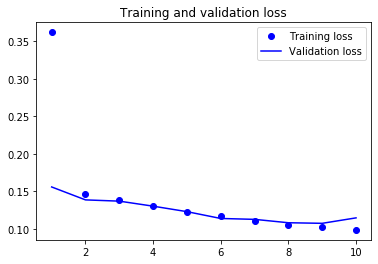

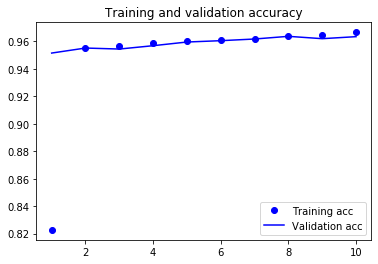

<Figure size 432x288 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [86]:
test_labels = test_gen.classes

In [87]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [88]:
test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

In [89]:
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

411/411 [==============================] - 176s 429ms/step


In [90]:
predictions.shape

(4104, 2)

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [96]:
test_labels.shape

(4104,)

In [97]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[1994   59]
 [  90 1961]]


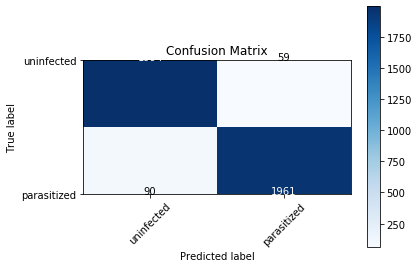

In [98]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [99]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [100]:
# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

  uninfected       0.96      0.97      0.96      2053
 parasitized       0.97      0.96      0.96      2051

    accuracy                           0.96      4104
   macro avg       0.96      0.96      0.96      4104
weighted avg       0.96      0.96      0.96      4104



In [101]:
#
# put the val image_id, labels and predictions into a dataframe

val_pred_dict = {
    'image_id': test_gen.filenames,
    'val_labels': test_gen.classes,
    'val_preds': predictions.argmax(axis=1)
}

df_val_preds = pd.DataFrame(val_pred_dict)


# Adjust the file names

# sample image name: a_uninfected/C100P61ThinF_IMG_20150918_144104_...
# we want just this part: C100P61ThinF_IMG_20150918_144104_...

def adjust_file_names(x):
    # split into a list based on '/'
    fname = x.split('/')
    # chose the second item in the list which is the image name
    fname = fname[1]
    
    return fname

df_val_preds['image_id'] = df_val_preds['image_id'].apply(adjust_file_names)


# savedf_val_preds so we can analyze the results later
pickle.dump(df_val_preds,open('df_val_preds.pickle','wb'))

# code to load the dataframe
# df_val_preds = pickle.load(open('df_val_preds','rb'))


#df_val_preds.head()

In [102]:
df_val_preds.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144104_cell_21.png,0,0
1,C100P61ThinF_IMG_20150918_144104_cell_48.png,0,0
2,C100P61ThinF_IMG_20150918_144823_cell_126.png,0,0
3,C100P61ThinF_IMG_20150918_144823_cell_127.png,0,0
4,C100P61ThinF_IMG_20150918_145422_cell_3.png,0,0


In [103]:
# filter out those rows where the model made correct predictions
df_correct = df_val_preds[df_val_preds['val_labels'] == df_val_preds['val_preds']]

# filter out those rows where the model made wrong predictions
df_wrong = df_val_preds[df_val_preds['val_labels'] != df_val_preds['val_preds']]

print(df_correct.shape)
print(df_wrong.shape)

(3955, 3)
(149, 3)


In [104]:
df_correct.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144104_cell_21.png,0,0
1,C100P61ThinF_IMG_20150918_144104_cell_48.png,0,0
2,C100P61ThinF_IMG_20150918_144823_cell_126.png,0,0
3,C100P61ThinF_IMG_20150918_144823_cell_127.png,0,0
4,C100P61ThinF_IMG_20150918_145422_cell_3.png,0,0


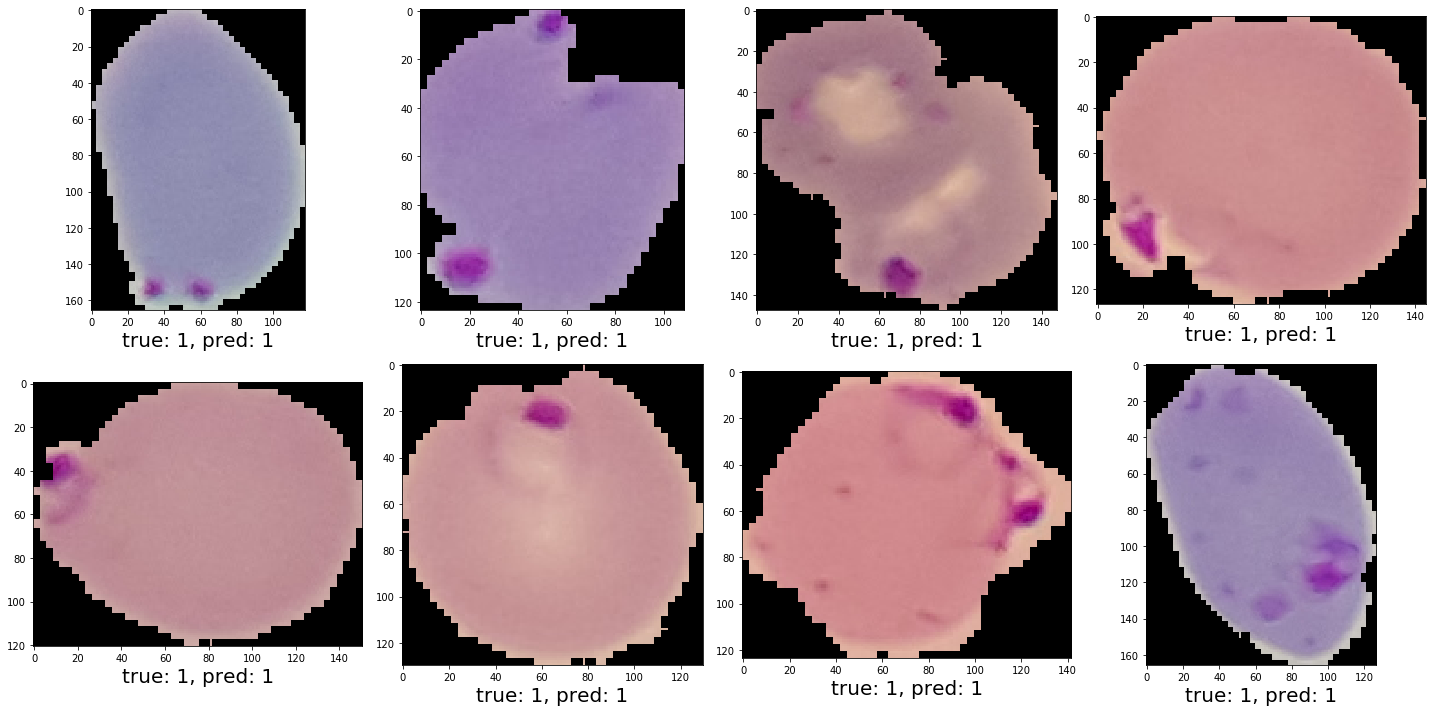

In [106]:
df_1 = df_correct[df_correct['val_labels'] == 1]

# we see diffrent images each time the code is run.

path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 1', fontsize=20)

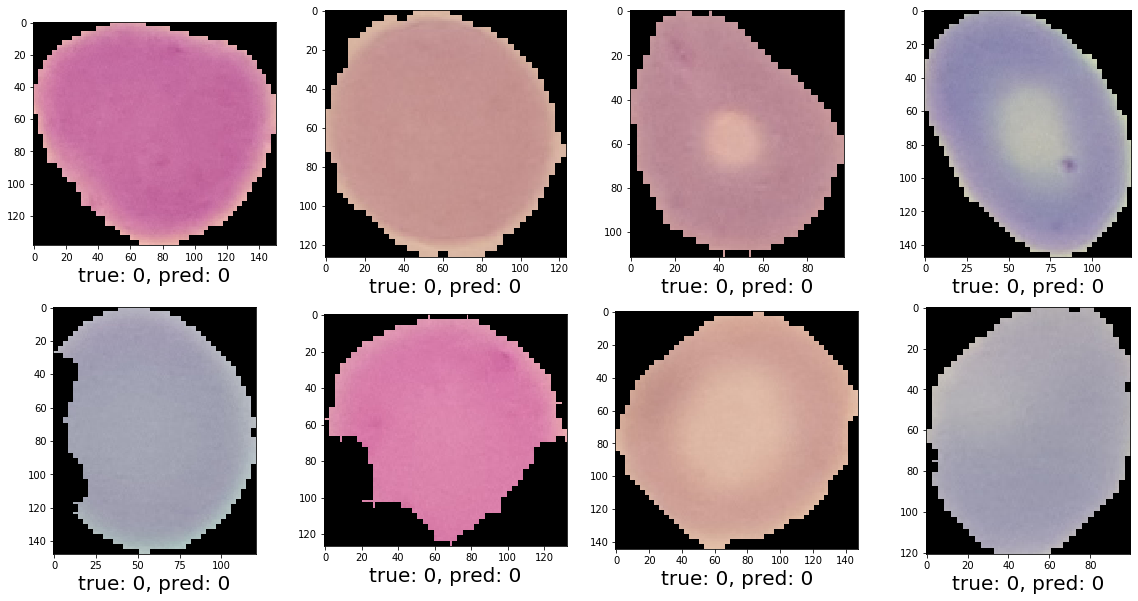

In [107]:
df_0 = df_correct[df_correct['val_labels'] == 0]

# we see diffrent images each time the code is run.

path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 0', fontsize=20)

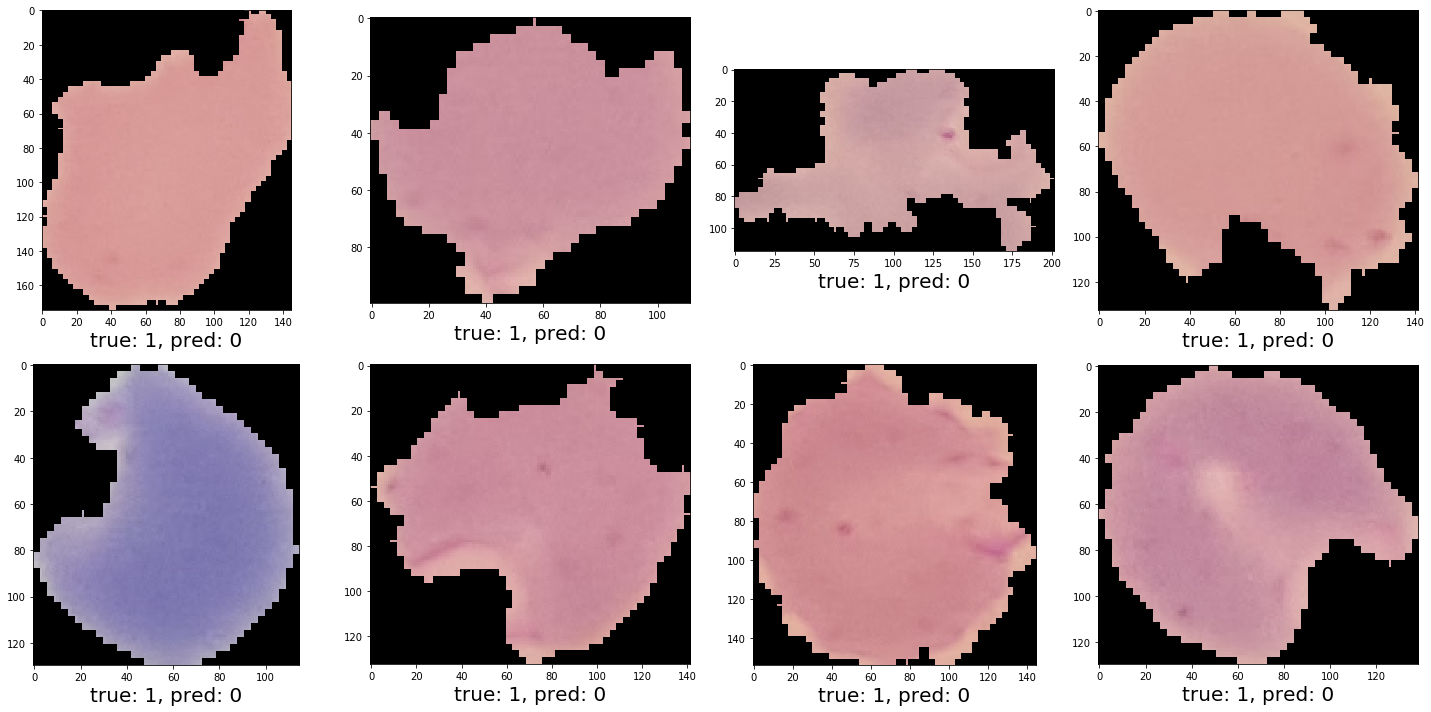

In [108]:
df_1 = df_wrong[df_wrong['val_labels'] == 1]


# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 0', fontsize=20)

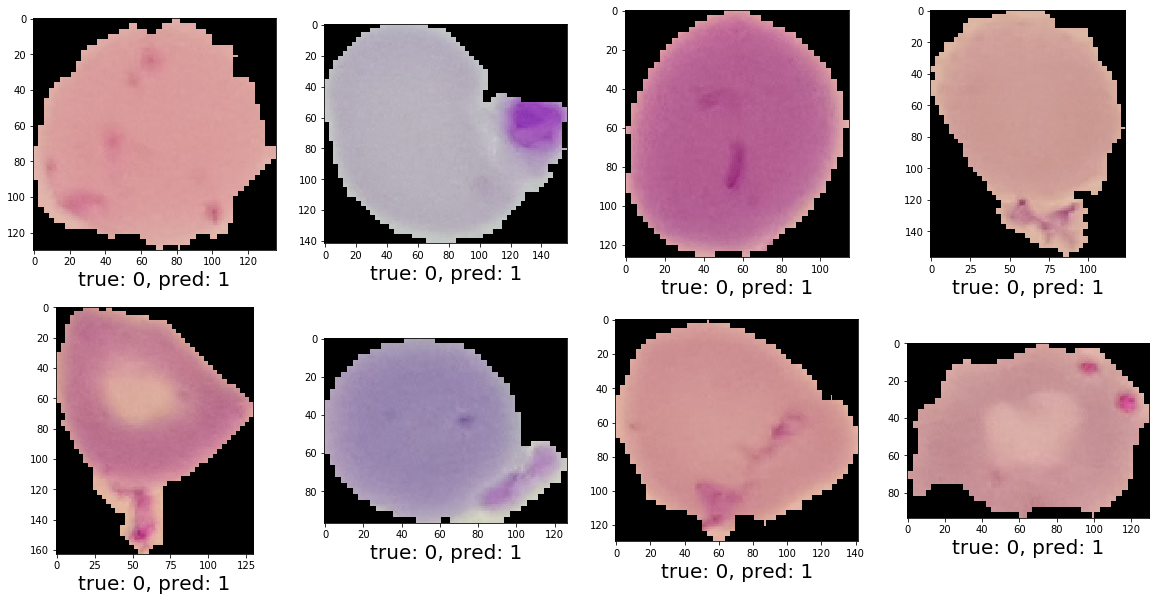

In [110]:
df_0 = df_wrong[df_wrong['val_labels'] == 0]

# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = './cell_images/Uninfected/'
path_parasitized = './cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 1', fontsize=20)

In [112]:
#
# ==============================
# Create the 5 Folds
# ==============================

# shuffle df_combined and change the name to df_data
df_data = shuffle(df_combined.copy())

# train_test_split
y = df_data['target']

# initialize kfold
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=101)

# define y for stratification
y = df_data['target']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df_train, y)

# Put the folds into a list. This is a list of tuples.
# y was set above.
fold_list = list(kf.split(df_data, y))


# ==============================
# Loop Through the Folds
# ==============================

# create a list to store the predictions
val_pred_list = []

# create a list to store the scores
val_acc_list = []
val_loss_list = []
val_auc_list = []


for i, fold in enumerate(fold_list):

    # Delete the image data directory we created to prevent a Kaggle error.
    # Kaggle allows a max of 500 files to be saved.
    
    if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')
        
        
    
    # set df_data
    df_data = df_combined.copy()
    
    print('=== Fold_' + str(i) + ' ===')
    print('\n')

    # map the train and val index values to dataframe rows
    df_train = df_data[df_data.index.isin(fold[0])]
    df_val = df_data[df_data.index.isin(fold[1])]
    



    # ==============================
    # Create a Directory Structure
    # ==============================

    # Create a new directory
    base_dir = 'base_dir'
    os.mkdir(base_dir)


    #[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

    # now we create 2 folders inside 'base_dir':

    # train
        # a_uninfected
        # b_parasitized

    # val
        # a_uninfected
        # b_parasitized


    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)


    # [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    a_uninfected = os.path.join(train_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(train_dir, 'b_parasitized')
    os.mkdir(b_parasitized)


    # create new folders inside val_dir
    a_uninfected = os.path.join(val_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(val_dir, 'b_parasitized')
    os.mkdir(b_parasitized)



    # =================================
    # Transfer the Images into Folders
    # =================================

    # Set the image_id as the index in df_data
    df_data.set_index('image_id', inplace=True)

    # Get a list of images in each of the two folders

    path_uninfected = './cell_images/Uninfected'
    path_parasitized = './cell_images/Parasitized'

    folder_1 = os.listdir(path_uninfected)
    folder_2 = os.listdir(path_parasitized)

    # Get a list of train and val images
    train_list = list(df_train['image_id'])
    val_list = list(df_val['image_id'])



    # Transfer the train images

    for image in train_list:

        fname = image
        target = df_data.loc[image,'target']

        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'

        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)



    # Transfer the val images

    for image in val_list:

        fname = image
        target = df_data.loc[image,'target']


        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'


        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

    # Print the number of images in each folder

    # train
    #print(len(os.listdir('base_dir/train_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

    # val
    #print(len(os.listdir('base_dir/val_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
    #print('\n')


    # ==============================
    # Set Up the Generators
    # ==============================

    train_path = 'base_dir/train_dir'
    valid_path = 'base_dir/val_dir'

    num_train_samples = len(df_train)
    num_val_samples = len(df_val)
    train_batch_size = BATCH_SIZE
    val_batch_size = BATCH_SIZE


    train_steps = np.ceil(num_train_samples / train_batch_size)
    val_steps = np.ceil(num_val_samples / val_batch_size)


    datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical')

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical',
                                            shuffle=False)
    
    print('\n')

    # ==============================
    # Set Up the Model Architecture
    # ==============================



    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))
    
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    #model.summary()



    # ==============================
    # Train the Model
    # ==============================


    model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
                  metrics=['accuracy'])

    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)


    callbacks_list = [checkpoint, reduce_lr]

    history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                                validation_data=val_gen,
                                validation_steps=val_steps,
                                epochs=NUM_EPOCHS, verbose=1,
                               callbacks=callbacks_list)



    # ==================================
    # Evaluate the Model on the Val Set
    # ==================================

    model.load_weights('model.h5')

    val_loss, val_acc = \
    model.evaluate_generator(test_gen, 
                            steps=val_steps)
    
    # append the acc score val_scores_list
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    
    # ==================================
    # Calculate the AUC Score
    # ==================================

    test_labels = test_gen.classes

    # make a prediction
    predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)
    
    # append the predictions to a list
    val_pred_list.append(predictions)
    
    val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))
    
    val_auc_list.append(val_auc)
    
    
    
    # ==================================
    # Print the Fold Scores
    # ==================================
    
    
    #print('\n')
    #print('Fold_' + str(i) + ' scores:\n')
    #print('val_loss:', val_loss)
    #print('val_acc:', val_acc)
    #print('val_auc:', val_auc)
    #print('\n')

    
    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

#print('\n')
#print('Average for of all 5 folds:\n')
#print('Average Accuracy: ', avg_acc)
#print('Average Loss: ', avg_loss)
#print('Average AUC: ', avg_auc)

=== Fold_0 ===


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


Epoch 1/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.3164 - acc: 0.8479
Epoch 00001: val_acc improved from -inf to 0.95120, saving model to model.h5
2205/2205 [==============================] - 2810s 1s/step - loss: 0.3163 - acc: 0.8480 - val_loss: 0.1555 - val_acc: 0.9512
Epoch 2/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.1497 - acc: 0.9532
Epoch 00002: val_acc did not improve from 0.95120
2205/2205 [==============================] - 2729s 1s/step - loss: 0.1497 - acc: 0.9532 - val_loss: 0.1646 - val_acc: 0.9479
Epoch 3/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.1383 - acc: 0.9564
Epoch 00003: val_acc improved from 0.95120 to 0.95773, saving model to model.h5
2205/2205 [==============================] - 2712s 1s/step - loss: 0.1382 - acc: 0.9564 - val_loss: 0.1295 - val_acc: 

Epoch 7/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.1119 - acc: 0.9623
Epoch 00007: val_acc did not improve from 0.96408
2205/2205 [==============================] - 2751s 1s/step - loss: 0.1119 - acc: 0.9622 - val_loss: 0.1420 - val_acc: 0.9592
Epoch 8/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.1058 - acc: 0.9641
Epoch 00008: val_acc did not improve from 0.96408

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2205/2205 [==============================] - 2765s 1s/step - loss: 0.1058 - acc: 0.9640 - val_loss: 0.1251 - val_acc: 0.9608
Epoch 9/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.0946 - acc: 0.9668
Epoch 00009: val_acc improved from 0.96408 to 0.96662, saving model to model.h5
2205/2205 [==============================] - 2782s 1s/step - loss: 0.0946 - acc: 0.9669 - val_loss: 0.1078 - val_acc: 0.9666
Epoch 10/10
2204/2205 [============================>.] - ETA: 1s - loss: 0.0907 - acc

In [123]:
print('Val Acc')
for item in val_acc_list:
    print(item)
    
print('\n')

print('Val Loss')
for item in val_loss_list:
    print(item)
    
print('\n')

print('Val AUC')
for item in val_auc_list:
    print(item)

    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

print('\n')
print('Average for of all 5 folds:\n')
print('Average Accuracy: ', avg_acc)
print('Average Loss: ', avg_loss)
print('Average AUC: ', avg_auc)

Val Acc
0.9617198791317046
0.964804060227293
0.9669811278257211
0.9653483264375321
0.9597096139203398


Val Loss
0.11052733316806936
0.11184075643491609
0.10551578605079352
0.10252903571535843
0.11126301530096279


Val AUC
0.9617823828302745
0.9648656139258297
0.9668634200752207
0.9654055640381282
0.9596280174599208


Average for of all 5 folds:

Average Accuracy:  0.9637126015085181
Average Loss:  0.10833518533402005
Average AUC:  0.9637089996658748


In [124]:
df_holdout.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C107P68ThinF_IMG_20150924_222233_cell_77.png,0,136,148,3,228,0,png
C39P4thinF_original_IMG_20150622_111326_cell_23.png,1,103,124,3,223,0,png
C70P31_ThinF_IMG_20150813_131708_cell_7.png,1,151,121,3,217,0,png
C39P4thinF_original_IMG_20150622_105554_cell_18.png,1,160,124,3,219,0,png
C60P21thinF_IMG_20150804_113602_cell_122.png,1,151,214,3,220,0,png


In [125]:
print(df_holdout.shape)
print(df_data.shape)

(200, 7)
(27358, 7)


In [147]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')



# ==============================
# Set df_train
# ==============================

# This variable was set above. Just setting it here again for clarity.
holdout_images_list = list(df_holdout['image_id'])

# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

df_train = df_data.copy()
df_val = df_holdout.copy()



# ==============================
# Create a Directory Structure
# ==============================

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)



# =================================
# Transfer the Images into Folders
# =================================

# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

# Set the image_id as the index in df_data
df_holdout.set_index('image_id', inplace=True)



# Get a list of images in each of the two folders

path_uninfected = './cell_images/Uninfected'
path_parasitized = './cell_images/Parasitized'

folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_holdout.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

# Print the number of images in each folder

# train
#print(len(os.listdir('base_dir/train_dir/a_uninfected')))
#print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
#print(len(os.listdir('base_dir/val_dir/a_uninfected')))
#print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
#print('\n')


# ==============================
# Set Up the Generators
# ==============================

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')


# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

print('\n')

# ==============================
# Set Up the Model Architecture
# ==============================


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

#model.summary()



# ==============================
# Train the Model
# ==============================


model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

# we are saving the model based on training accuracy
filepath = "final_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            epochs=NUM_FINAL_MODEL_EPOCHS, verbose=1,
                           callbacks=callbacks_list)


# ==================================
# Evaluate the Model on the Val Set
# ==================================

model.load_weights('final_model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)


# ==================================
# Calculate the AUC Score
# ==================================

test_labels = test_gen.classes

# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)


val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))




# ==================================
# Print the Scores
# ==================================

#print('\n')
#print('Accuracy: ', val_acc)
#print('Loss: ', val_loss)
#print('AUC: ', val_auc)


KeyError: 'image_id'

In [139]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

Confusion matrix, without normalization
[[2693   85]
 [ 137 2595]]


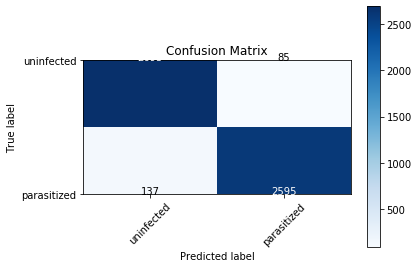

In [140]:
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [141]:
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)


# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

  uninfected       0.95      0.97      0.96      2778
 parasitized       0.97      0.95      0.96      2732

    accuracy                           0.96      5510
   macro avg       0.96      0.96      0.96      5510
weighted avg       0.96      0.96      0.96      5510



In [142]:
!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 61kB 190kB/s eta 0:00:01
     |████████████████████████████████| 104.6MB 107kB/s eta 0:00:01    |█████████                       | 29.7MB 372kB/s eta 0:03:22     |█████████████                   | 42.7MB 476kB/s eta 0:02:10     |██████████████████████▌         | 73.5MB 297kB/s eta 0:01:45     |████████████████████████▋       | 80.3MB 279kB/s eta 0:01:27     |█████████████████████████▍      | 83.1MB 1.2MB/s eta 0:00:19��█████████████████████▎ | 99.0MB 55kB/s eta 0:01:42
     |████████████████████████████████| 2.9MB 124kB/s eta 0:00:01
     |████████████████████████████████| 92kB 123kB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 835kB/s eta 0:00:01
     |████████████████████████████████| 450kB 655kB/s eta 0:00:01
     |████████████████████████████████| 61kB 396kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-a

     |████████████████████████████████| 92kB 191kB/s eta 0:00:01
     |████████████████████████████████| 583kB 325kB/s eta 0:00:01
     |████████████████████████████████| 61kB 255kB/s eta 0:00:01
     |████████████████████████████████| 307kB 234kB/s eta 0:00:01
     |████████████████████████████████| 163kB 87kB/s eta 0:00:01
     |████████████████████████████████| 163kB 158kB/s eta 0:00:01
     |████████████████████████████████| 61kB 212kB/s eta 0:00:01
     |████████████████████████████████| 143kB 109kB/s eta 0:00:01
     |████████████████████████████████| 133kB 159kB/s eta 0:00:01
     |████████████████████████████████| 81kB 657kB/s eta 0:00:01
     |████████████████████████████████| 153kB 324kB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7541 sha256=ed275fc89ce7a01654daa39116a20e3a762473a82e749f345fa28b7143421496
  Stored in directory: /home/kapil/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for 

In [145]:
!tensorflowjs_converter --input_format keras model.h5 tfjs/model